In [2]:
import numpy as np
import matplotlib.pyplot as plt

import pickle
import sys

from tqdm import tqdm_notebook

from nltk import ngrams

In [3]:
import itertools
from itertools import tee

import editdistance as ed

In [4]:
def plot_gr(gr, start=0, end=-1, log = False, all_ticks = False,  s=10):
    plt.figure(figsize=(s,s))
    if end == -1:
        end = gr.shape[0]
    if log:
        plt.imshow(np.log(gr[start:end,start:end] + 1))
    else:
        plt.imshow(gr[start:end,start:end])
    plt.colorbar()
    if all_ticks: 
        plt.xticks(np.arange(start,end))
        plt.yticks(np.arange(start,end))
    plt.show()

In [5]:
def plot_group(*args, s = 7):
    n = len(args) // 2
    
    plt.figure(figsize=(s,s))
    f, a = plt.subplots(1, n,figsize=(s,s))
    #f.set_figsize((s,s))
    for i in range(n):
        im = args[2*i]
        if args[2*i + 1]:
            im = np.log(im + 1)
        a[i].imshow(im)

    plt.show()

In [6]:
# Check randint
def generate_repeat(repeat_a, repeat_b):
    transition_pos = np.random.randint(0, len(repeat_a) + 1)
    return repeat_a[0:transition_pos] + repeat_b[transition_pos:]

In [7]:
class RepeatsDescr:
    def __init__(self, repeats):
        self.n = len(repeats)
        self.repeats = repeats
        self.repeat_to_n = dict(zip(self.repeats, np.arange(len(repeats))))
        self.n_to_repeat = dict(zip(np.arange(len(repeats)), self.repeats))
        self.mat = self._create_complementory_matrix()

    def add_repeat(self, repeat):
        self.repeats.append(repeat)
        self.repeat_to_n[repeat] = self.n
        self.n_to_repeat[self.n] = repeat
        self.n += 1
        self._update_complementory_matrix()
        
    def _create_complementory_matrix(self):
        mat = np.zeros((self.n, self.n))

        for r1, r2 in itertools.product(self.repeats, self.repeats):
            mat[self.repeat_to_n[r1]][self.repeat_to_n[r2]] = 1 - (ed.eval(r1,r2) / max(len(r1), len(r2)))
        return mat
    
    def _update_complementory_matrix(self):
        self.mat = np.pad(self.mat, ((0,1), (0,1)), mode = 'constant')
        
        for r in self.repeats:
            val = 1 - (ed.eval(r,repeats[-1]) / max(len(r), len(repeats[-1])))
            self.mat[self.repeat_to_n[r], self.repeat_to_n[repeats[-1]]] = val
            self.mat[self.repeat_to_n[repeats[-1]], self.repeat_to_n[r]] = val

In [8]:
repeats = ['aaaaaaaaaa',
           'aaaaaaaaab',
           'aaaaaaaabb']

repeats_descr = RepeatsDescr(repeats)

In [9]:
repeats_descr.add_repeat("aaaaaaabbb")

In [594]:
class Population:
    def __init__(self,
                 initial_population, 
                 primers_counts,
                 max_len = 10):
        self.max_len = max_len
        self.max_size = (sum(primers_counts.values()) + len(initial_population))
        
        self.p = np.ones((self.max_size, self.max_len)).astype(int) * -1
        
        pos = 0
        for arr in initial_population:
            self.p[pos, (max_len - len(arr)) // 2: (max_len - len(arr)) // 2 + len(arr)] = arr
            pos += 1
        for k, v in primers_counts.items():
            self.p[pos: pos + v, max_len // 2 - 1] = k
            pos += v
        
        self.glue_mask = self.p[:, ::2].flatten() != -1
        
        if V == 'DEBUG' or V == 'DEBUG_1':
            print(self.p, "\n")   
            
    
    def get_rep_pos_by_ind(self, ind):
        return (ind * 2 // self.p.shape[1], ind * 2 % self.p.shape[1])
    
    
    def get_rep_by_ind(self, ind):
        return self.p[:,::2].flatten()[ind]

    def _recalc_glue_mask(self):
        self.glue_mask = self.p[:, ::2].flatten() != -1

In [566]:
from copy import deepcopy

In [707]:
class PCR:
    def __init__(self, population, repeats_descr):
        self.fp = population
        self.bp = deepcopy(population)
#         self.ni = population.p.shape[0]
#         self.nj = population.p.shape[1]
        
        self.comp_mat = np.zeros((self.fp.glue_mask.shape[0], self.fp.glue_mask.shape[0]))
        
        for i in np.where(self.fp.glue_mask)[0]:
            for j in np.where(self.bp.glue_mask)[0]:
                self.comp_mat[i][j] = repeats_descr.mat[self.fp.get_rep_by_ind(i), self.fp.get_rep_by_ind(j)]
                
    def _annealing(self):
        self.anneal_all = (np.random.random(size = self.comp_mat.shape) < self.comp_mat).astype(int)
        self.anneal = np.zeros_like(self.comp_mat)
        indexes = np.arange(self.anneal_all.shape[0])[self.anneal_all.sum(1) != 0]
        #np.random.shuffle(indexes)
        for i in indexes:
            row = self.anneal_all[i]
  
            j = np.random.choice(np.arange(self.comp_mat.shape[0]), size = 1, p = row.astype(float) / row.sum())
            
            if np.random.random() < 0.5 * self.anneal_all[i, j]:
                self.anneal[i, j] = 1
                self.anneal[j, i] = 1
            
            self.anneal_all[i] = 0
            self.anneal_all[:, i] = 0
            self.anneal_all[j] = 0
            self.anneal_all[:, j] = 0
            
            
    def _amplify(self):
        
        for f, b in zip(np.where(self.anneal == 1)[0], np.where(self.anneal == 1)[1]):
            fi, fj = self.fp.get_rep_pos_by_ind(f)
            bi, bj = self.bp.get_rep_pos_by_ind(b)
            print(f, b, '; ', fi, fj, '; ', bi, bj)
            
        self.glue_f_to_b(fi, fj, bi, bj)
        self.glue_b_to_f(fi, fj, bi, bj)
            
            
    def glue_f_to_b(self, fi, fj, bi, bj):
        if self.fp.p[fi][fj + 1] == -1 and fj + 2 != self.fp.max_len:
            copy_part = self.bp.p[bi][bj:][self.bp.p[bi][bj:] != -1][: self.fp.max_len - fi]
            self.fp.p[fi][fj:fj + copy_part.shape[0]] = copy_part
    
    
    def glue_b_to_f(self, fi, fj, bi, bj):
        if bj > 0 and self.bp.p[bi][bj - 1] == -1:
            copy_part = self.fp.p[fi][:fj][self.fp.p[fi][:fj] != -1][fj - bj - 1:fj]
            self.bp.p[bi][bj - copy_part.shape[0]:bj] = copy_part
            
            
    def print_glue_points(self):
        for f, b in zip(np.where(self.anneal == 1)[0], np.where(self.anneal == 1)[1]):
            fi, fj = self.fp.get_rep_pos_by_ind(f)
            bi, bj = self.bp.get_rep_pos_by_ind(b)
            print(f, b, '; ', fi, fj, '; ', bi, bj)
        
        

In [708]:
V = 'DEBUG_2'

In [709]:
p_list = [[0,10, 0,], [0, 20, 0,]]
primers_num = {0:2}
p = Population(p_list, primers_num, max_len=8)

In [710]:
p.p

array([[-1, -1,  0, 10,  0, -1, -1, -1],
       [-1, -1,  0, 20,  0, -1, -1, -1],
       [-1, -1, -1,  0, -1, -1, -1, -1],
       [-1, -1, -1,  0, -1, -1, -1, -1]])

In [711]:
pcr = PCR(p, repeats_descr)

In [724]:
pcr.fp.p

array([[-1, -1,  0, 10,  0, -1, -1, -1],
       [-1, -1,  0, 20,  0, -1, -1, -1],
       [-1, -1, -1,  0, 10,  0, -1, -1],
       [-1, -1, -1,  0, -1, -1, -1, -1]])

In [728]:
pcr.bp.p

array([[-1, -1,  0, 10,  0, -1, -1, -1],
       [-1, -1,  0, 20,  0, -1, -1, -1],
       [-1,  0, 20,  0, -1, -1, -1, -1],
       [-1, -1, -1,  0, -1, -1, -1, -1]])

In [726]:
pcr.glue_f_to_b(2,3,0,2)

In [727]:
pcr.glue_b_to_f(1,4, 2,1)

In [688]:
if bj > 0 and self.bp.p[bi][bj - 1] == -1:
    copy_part = self.fp.p[fi][:fj][self.fp.p[fi][:fj] != -1][fj - bj:fj]
    self.fp.p[bi][bj - copy_part.shape[0]:bj] = copy_part

NameError: name 'bj' is not defined

In [641]:
pcr.print_glue_points()

1 2 ;  0 2 ;  0 4
2 1 ;  0 4 ;  0 2
5 6 ;  1 2 ;  1 4
6 5 ;  1 4 ;  1 2


In [612]:
pcr._amplify()

1 17 ;  0 2 ;  3 4
3 22 ;  0 6 ;  4 4
6 6 ;  1 2 ;  1 2
7 8 ;  1 4 ;  1 6
8 7 ;  1 6 ;  1 4
17 1 ;  3 4 ;  0 2
22 3 ;  4 4 ;  0 6
27 27 ;  5 4 ;  5 4


/home/anton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/home/anton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less


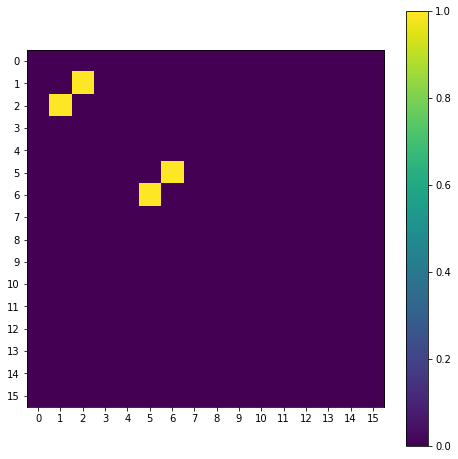

In [640]:
pcr._annealing()
plot_gr(pcr.anneal, s  = 8, all_ticks=1)

In [423]:
pcr._amplify()

0 (0, 1)
1 (0, 3)
2 (0, 5)
3 (1, 1)
4 (1, 3)
5 (1, 5)
5 (1, 5)
6 (2, 1)
8 (2, 5)
8 (2, 5)
8 (2, 5)
8 (2, 5)
12 (4, 1)
12 (4, 1)
12 (4, 1)
16 (5, 3)
16 (5, 3)
20 (6, 5)
20 (6, 5)


In [412]:
for a, b in zip(np.where(pcr.anneal == 1)[0], np.where(pcr.anneal == 1)[1]):
    print(a)

0
1
2
2
3
4
4
5
5
6
6
8
12
12
16
20
20
20


In [397]:
np.where(pcr.anneal == 1)[0]

array([ 0,  1,  2,  3,  4,  5,  5,  5,  6,  8,  8,  8, 12, 12, 12, 16, 20])

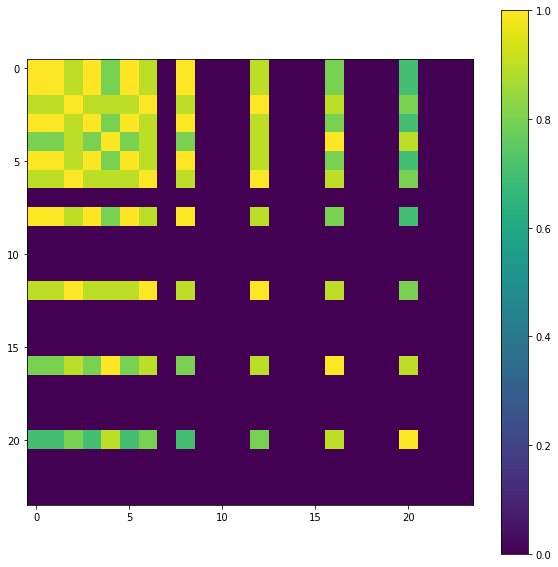

In [354]:
plot_gr(pcr.comp_mat)

In [101]:
p.bp

array([[ 0.,  0.,  0.,  0.,  1.,  1.,  2.,  0., -1.],
       [ 0.,  2.,  3.,  0.,  4.,  1., -1., -1., -1.],
       [ 1.,  0., -1., -1., -1., -1., -1., -1., -1.],
       [ 1.,  1., -1., -1., -1., -1., -1., -1., -1.],
       [ 1.,  2., -1., -1., -1., -1., -1., -1., -1.],
       [ 1.,  3., -1., -1., -1., -1., -1., -1., -1.]])

In [106]:
p.fp[:,1:]

array([[ 0.,  0.,  0.,  1.,  1.,  2.,  0., -1.],
       [ 2.,  3.,  0.,  4.,  1., -1., -1., -1.],
       [ 0., -1., -1., -1., -1., -1., -1., -1.],
       [ 1., -1., -1., -1., -1., -1., -1., -1.],
       [ 2., -1., -1., -1., -1., -1., -1., -1.],
       [ 3., -1., -1., -1., -1., -1., -1., -1.]])

In [92]:
complementaries = np.zeros((24,24))

In [104]:
sh = p.bp[:,1:].shape

In [107]:
p.bp[:,1::2]

array([[ 0.,  0.,  1.,  0.],
       [ 2.,  0.,  1., -1.],
       [ 0., -1., -1., -1.],
       [ 1., -1., -1., -1.],
       [ 2., -1., -1., -1.],
       [ 3., -1., -1., -1.]])

In [ ]:
complementary_b_to_f = np.zeros

In [316]:
m = repeats_descr.mat

In [312]:
p.amplify(repeats_descr.mat, {})

[[0.  0.  0.  0. ]
 [1.  0.9 0.8 0.7]
 [1.  0.9 0.8 0.7]
 [0.9 1.  0.9 0.8]
 [1.  0.9 0.8 0.7]
 [0.8 0.9 1.  0.9]
 [1.  0.9 0.8 0.7]
 [0.9 1.  0.9 0.8]
 [0.9 1.  0.9 0.8]]


In [315]:
for x in p.p.flatten():
    print(x)

-1
-1
0
0
0
1
1
2
0
-1
2
3
0
4
1
-1
1
5
2
-1


In [317]:
m

array([[1. , 0.9, 0.8, 0.7],
       [0.9, 1. , 0.9, 0.8],
       [0.8, 0.9, 1. , 0.9],
       [0.7, 0.8, 0.9, 1. ]])

In [ ]:
np.random.choice(np.arange(12).reshape((3,4)), size = 4, p = 

In [267]:
def single_amplify(to_amplify, population=None, v = False):
    if population is None:
        population = [x for x in to_amplify]
    
    new = []
    for chain in to_amplify:
        start = np.random.randint(0, len(chain) - 1)
        stop = False
        end = np.random.randint(start + 1, len(chain))

        new_chain = []
        pointer = start

        while not stop:
            switch = np.random.rand() < SWITCH_PROB

            if v:
                print(chain, new_chain, switch)
            if switch:
                chain = population[np.random.randint(0, len(population))]
                pointer = np.random.randint(1, len(chain))

            if np.random.rand() < STOP_PROB:
                stop = True

            if len(new_chain) >= end - start:
                stop = True

            if pointer < len(chain):
                new_chain.append(chain[pointer])
            else:
                stop = True

            pointer += 1 

        if len(new_chain) > 2:
            new.append(new_chain)
    
    return [x[::-1] for x in new]

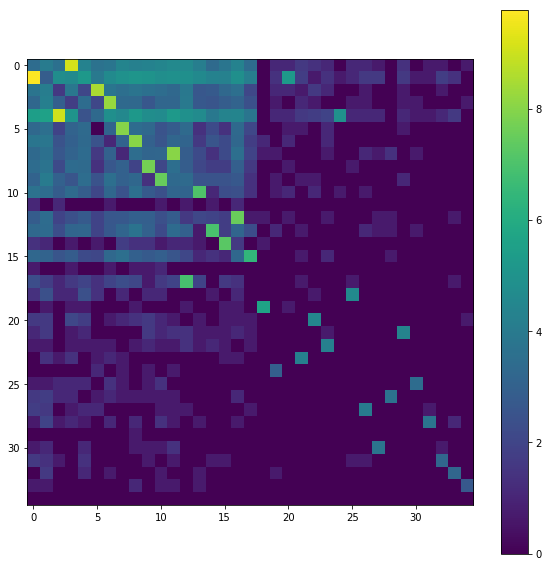

In [126]:
plot_gr(np.load("../../data/graphs/ES3_22.npy")[:35,:35], log = 1)

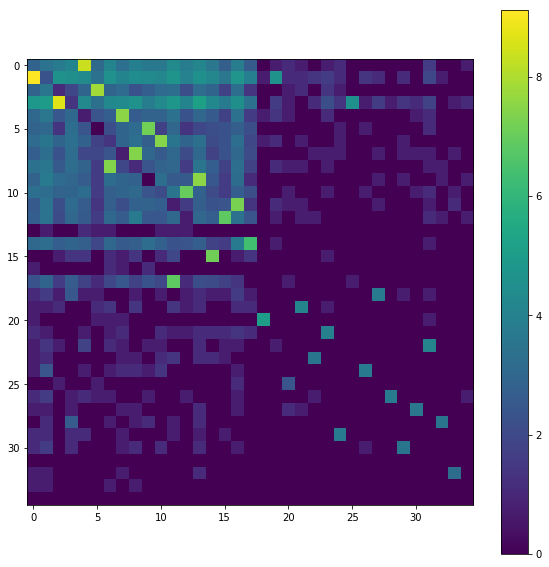

In [127]:
plot_gr(np.load("../../data/graphs/ES4_22.npy")[:35,:35], log = 1)